In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

#import aesara
#import aesara.tensor as at

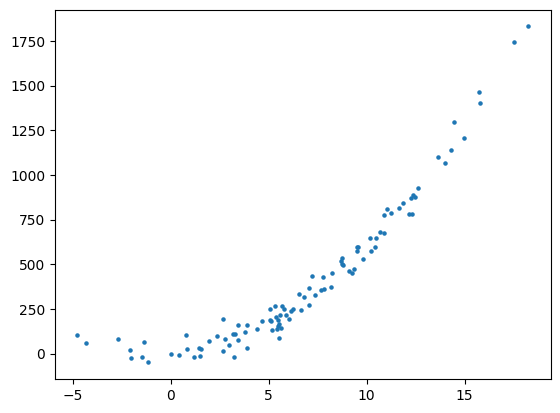

In [2]:
# 模拟数据
X = np.random.randn(100) * 5 + 7
error = np.random.randn(100) * 50
Y_obs = 5 * X ** 2 + 10 * X + error

plt.scatter(X, Y_obs, s=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


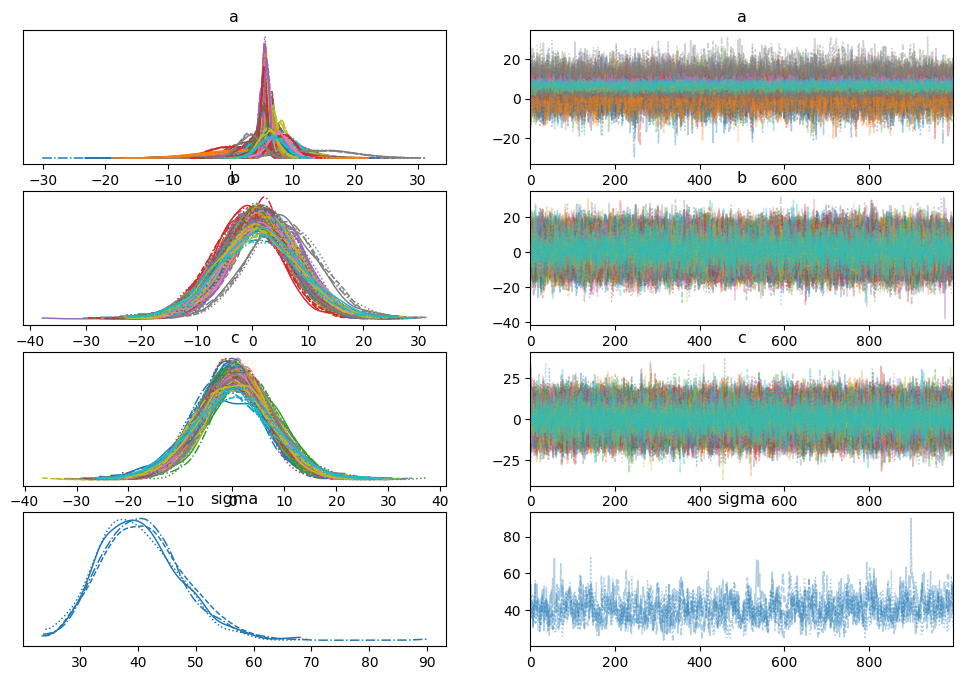

In [3]:
lambda_l1tf = 0.1



with pm.Model() as model_tv:
    a = pm.Normal('a', mu=0, sigma=10, shape=100)
    b = pm.Normal('b', mu=0, sigma=10, shape=100)
    c = pm.Normal('c', mu=0, sigma=10, shape=100)
    
    Y_pred = a * X ** 2 + b * X + c

    sigma = pm.HalfNormal('sigma', sigma=50)
    likelihood = pm.Normal('Y_obs', mu=Y_pred, sigma=sigma, observed=Y_obs)

    dif_a = sum(abs(a[1:] - a[:-1]))
    dif_b = sum(abs(b[1:] - b[:-1]))
    dif_c = sum(abs(c[1:] - c[:-1]))

    
    pm.Potential(f'a_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), dif_a))
    pm.Potential(f'b_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), dif_b))
    pm.Potential(f'c_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), dif_c))

    # 采样
    trace_tv = pm.sample(1000, tune=1000, return_inferencedata=True)

# 绘制追踪图
pm.plot_trace(trace_tv)
plt.show()
#2.29.8 2.33.0

In [4]:
X_test = np.linspace(np.floor(X.min()), np.ceil(X.max()), 100)

# 真值
Y_true = 5 * X_test ** 2 + 10 * X_test

# 计算后验平均值
a_posterior_mean = trace_tv.posterior["a"].mean().values
b_posterior_mean = trace_tv.posterior["b"].mean().values
c_posterior_mean = trace_tv.posterior["c"].mean().values
Y_fit = a_posterior_mean * X_test ** 2 + b_posterior_mean * X_test + c_posterior_mean

# 计算后验标准差
a_posterior_std = trace_tv.posterior["a"].std().values
b_posterior_std = trace_tv.posterior["b"].std().values
c_posterior_std = trace_tv.posterior["c"].std().values
Y_errorpred = a_posterior_std * X_test ** 2 + b_posterior_std * X_test + c_posterior_std

edge1 = Y_fit + Y_errorpred
edge2 = Y_fit - Y_errorpred

crosspoint = 0
for i in range(len(X_test)):
    if edge1[i] < edge2[i]:
        crosspoint = i
        break

MSE = np.mean((Y_fit - Y_true) ** 2)

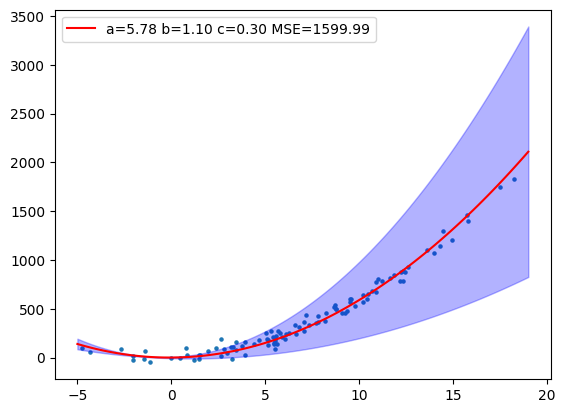

In [5]:
# 绘制填充区间
# 绘制数据点
plt.scatter(X, Y_obs, s=5)

# 绘制后验平均拟合线
plt.plot(X_test, Y_fit, color='red', label='a={:.2f} b={:.2f} c={:.2f} MSE={:.2f}'.format(
         a_posterior_mean, b_posterior_mean, c_posterior_mean, MSE))

if crosspoint:
    plt.fill_between(X_test[:crosspoint], edge2[:crosspoint], edge1[:crosspoint], color='blue', alpha=0.3, 
                     label='Uncertainty')
    plt.fill_between(X_test[crosspoint:], edge1[crosspoint:], edge2[crosspoint:], color='blue', alpha=0.3)
else:
    plt.fill_between(X_test, edge2, edge1, color='blue', alpha=0.3)

# 显示图例
plt.legend()

# 显示图表
plt.show()

In [12]:
import scipy.sparse
import numpy as np
n = 5
e = np.ones((1, n))

f = np.vstack((e, -2*e, 3*e))
print(f)

D = scipy.sparse.spdiags(f, range(3), n-2, n)
print(D.toarray())

[[ 1.  1.  1.  1.  1.]
 [-2. -2. -2. -2. -2.]
 [ 3.  3.  3.  3.  3.]]
[[ 1. -2.  3.  0.  0.]
 [ 0.  1. -2.  3.  0.]
 [ 0.  0.  1. -2.  3.]]
